## **Table of Contents**

1. Preparing Data
2. Baseline Model
3. Model Evaluation
4. Convolutional Neural Network
5. Comparing both models
6. Saving and loading the model

### Preparing Data

In [39]:
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from tqdm.auto import tqdm

In [25]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [3]:
training_data = datasets.FashionMNIST(
    root= 'data',
    train= True,
    download= True,
    transform= ToTensor(),
    target_transform= None
)

testing_data = datasets.FashionMNIST(
    root= 'data',
    train= False,
    download= True,
    transform= ToTensor(),
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data\FashionMNIST\raw\train-images-idx3-ubyte.gz to data\FashionMNIST\raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to data\FashionMNIST\raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to data\FashionMNIST\raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to data\FashionMNIST\raw



In [4]:
image, label = training_data[0]
image.shape

torch.Size([1, 28, 28])

In [6]:
class_names = training_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

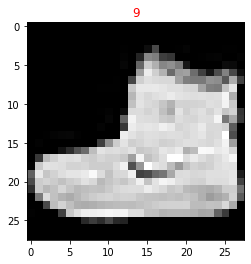

In [12]:
plt.imshow(image.squeeze(), cmap= 'gray')
plt.title(label, color = 'red');

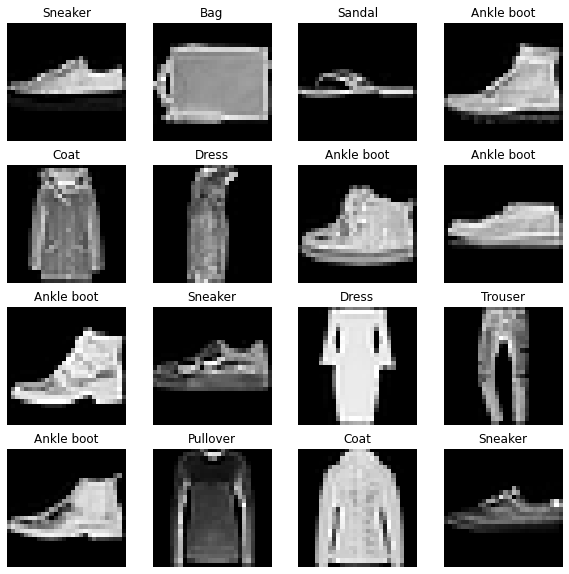

In [18]:
fig = plt.figure(figsize = (10, 10))
for i in range(1, 17):
    idx = torch.randint(0, len(training_data), size=[1]).item()
    image, label = training_data[idx]
    fig.add_subplot(4, 4, i)
    plt.imshow(image.squeeze(), cmap= 'gray')
    plt.title(class_names[label])
    plt.axis(False)

In [22]:
BATCH_SIZE = 32

training_dataloader = DataLoader(
    training_data, BATCH_SIZE, shuffle= True
)

test_dataloader = DataLoader(
    testing_data, BATCH_SIZE, shuffle= False
)

In [23]:
train_features_batch, train_labels_batch = next(iter(training_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

### Baseline Model

In [27]:
class Model1(nn.Module):
    def __init__(self, input_shape:int, hidden_units:int, output_shape:int) -> None:
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features= hidden_units),
            nn.ReLU(),
            nn.Linear(in_features= hidden_units, out_features= output_shape),
            nn.ReLU()
        )

    def forward(self, x):
        return self.layers(x)

In [29]:
torch.manual_seed(42)
model1 = Model1(input_shape= 28 * 28, hidden_units= 10, output_shape= len(class_names)).to(device)
next(model1.parameters()).device

device(type='cpu')

In [30]:
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.SGD(params= model1.parameters(), lr= 0.01)

In [33]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    return (correct / len(y_pred)) * 100

In [37]:
def train_step(
        model: torch.nn.Module,
        data_loader: torch.utils.data.DataLoader,
        loss_fn: loss_fn,
        optimizer: torch.optim.Optimizer,
        accuracy_fn,
        device: torch.device = device
):
    train_loss, train_acc = 0, 0
    model.to(device)
    for batch, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true= y, y_pred = y_pred.argmax(dim=1))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.3f} | Train accuracy: {train_acc:.2f}%")


In [38]:
def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval() 
    with torch.inference_mode(): 
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            
            test_pred = model(X)
            
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))
        
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.3f} | Test accuracy: {test_acc:.2f}%\n")

In [40]:
epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n------")
    train_step(data_loader=training_dataloader, 
        model=model1, 
        loss_fn=loss_fn,
        optimizer=optim,
        accuracy_fn=accuracy_fn
    )
    test_step(data_loader=test_dataloader,
        model=model1,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn
    )


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
------
Train loss: 1.430 | Train accuracy: 53.82%
Test loss: 1.126 | Test accuracy: 61.12%

Epoch: 1
------
Train loss: 1.033 | Train accuracy: 64.74%
Test loss: 0.998 | Test accuracy: 64.83%

Epoch: 2
------
Train loss: 0.960 | Train accuracy: 66.03%
Test loss: 0.961 | Test accuracy: 65.46%



### Model Evaluation

In [52]:
def eval_model(model: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               accuracy_fn, 
               device: torch.device = device):
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
        
        loss /= len(data_loader)
        acc /= len(data_loader)
    return {
        "model_name": model.__class__.__name__, 
        "model_loss": loss.item(),
        "model_acc": round(acc, 2)
    }

In [53]:
model_1_results = eval_model(model=model1, data_loader=test_dataloader,
    loss_fn=loss_fn, accuracy_fn=accuracy_fn,
    device=device
)
model_1_results

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.2336e+00,
         0.0000e+00, 1.3862e+00, 0.0000e+00, 0.0000e+00],
        [8.3317e-01, 0.0000e+00, 8.5805e+00, 0.0000e+00, 5.0561e+00, 0.0000e+00,
         7.1018e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [7.8287e-02, 1.0631e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 1.7357e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 8.6472e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 5.0597e-01, 0.0000e+00, 0.0000e+00],
        [2.5643e+00, 0.0000e+00, 2.1198e+00, 0.0000e+00, 4.5955e-01, 0.0000e+00,
         3.5156e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.3335e+00, 7.8632e+00, 0.0000e+00, 0.0000e+00, 1.7774e+00, 0.0000e+00,
         0.0000e+00, 2.8020e-01, 0.0000e+00, 0.0000e+00],
        [2.1716e+00, 1.0435e+00, 2.9953e+00, 0.0000e+00, 6.1554e+00, 0.0000e+00,
         4.3621e+00, 0.0000e+00, 3.9447e-01, 5.8137e-02],
        [9.0336e-01, 0.0000

{'model_name': 'Model1', 'model_loss': 0.960881233215332, 'model_acc': 65.46}

### Convolutional Neural Network

In [46]:
class CNNModel(nn.Module):
    def __init__(self, input_shape:int, hidden_units:int, output_shape:int) -> None:
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(
                in_channels=input_shape,
                out_channels=hidden_units,
                kernel_size= 3,
                stride=1,
                padding=1
                ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size= 3,
                stride=1,
                padding=1
                ),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.block2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding= 1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding= 1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features= hidden_units * 7 * 7, out_features= output_shape)
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.classifier(x)
        return x
    

torch.manual_seed(42)
model2 = CNNModel(input_shape= 1, hidden_units= 10, output_shape=len(class_names)).to(device)
model2

CNNModel(
  (block1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [47]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model2.parameters(), 
                             lr=0.1)

In [49]:
epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=training_dataloader, 
        model=model2, 
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device
    )
    test_step(data_loader=test_dataloader,
        model=model2,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
    )

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.579 | Train accuracy: 79.09%
Test loss: 0.399 | Test accuracy: 84.98%

Epoch: 1
---------
Train loss: 0.356 | Train accuracy: 87.21%
Test loss: 0.364 | Test accuracy: 86.25%

Epoch: 2
---------
Train loss: 0.317 | Train accuracy: 88.49%
Test loss: 0.333 | Test accuracy: 88.09%



In [50]:
model_2_results = eval_model(
    model=model2,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn
)
model_2_results

{'model_name': 'CNNModel',
 'model_loss': 0.3328368067741394,
 'model_acc': 88.09}

### Comparing both models

In [51]:
import pandas as pd
compare_results = pd.DataFrame([model_1_results, model_2_results])
compare_results

,model_name,model_loss,model_acc
0,Model1,0.960881,65.46
1,CNNModel,0.332837,88.09


### Making predictions

In [57]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            sample = torch.unsqueeze(sample, dim=0).to(device) 
            pred_logit = model(sample)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)
            pred_probs.append(pred_prob.cpu())
    return torch.stack(pred_probs)

In [58]:
import random
random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(testing_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

In [60]:
pred_probs= make_predictions(model= model2, 
                             data=test_samples)

pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([5, 0, 7, 2, 3, 0, 4, 7, 1])

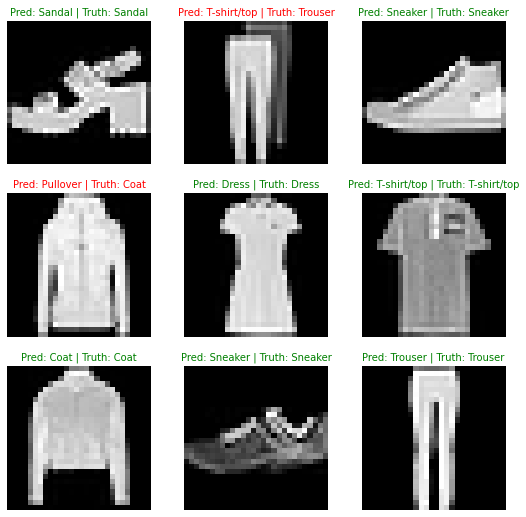

In [61]:
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  plt.subplot(nrows, ncols, i+1)
  plt.imshow(sample.squeeze(), cmap="gray")
  pred_label = class_names[pred_classes[i]]
  truth_label = class_names[test_labels[i]] 
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g")
  else:
      plt.title(title_text, fontsize=10, c="r")
  plt.axis(False);

In [62]:
y_preds = []
model2.eval()
with torch.inference_mode():
  for X, y in test_dataloader:
    X, y = X.to(device), y.to(device)
    y_logit = model2(X)
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1) 
    y_preds.append(y_pred.cpu())
y_pred_tensor = torch.cat(y_preds)

In [ ]:
import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(testing_data.targets, y_pred_tensor, figsize=(6,6), cmap= 'YlGnBu');